In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import roc_curve,roc_auc_score,accuracy_score
from sklearn.model_selection import GridSearchCV
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.neural_network import MLPClassifier


# Problem #1: Clustering

# A leading bank wants to develop a customer segmentation to give promotional offers to its customers. They collected a sample that summarizes the activities of users during the past few months. You are given the task to identify the segments based on credit card usage.

In [2]:
cust = pd.read_csv("bank_marketing_part1_Data.csv")

In [3]:
cust.head()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping
0,19.94,16.92,0.8752,6.675,3.763,3.252,6.550
1,15.99,14.89,0.9064,5.363,3.582,3.336,5.144
2,18.95,16.42,0.8829,6.248,3.755,3.368,6.148
3,10.83,12.96,0.8099,5.278,2.641,5.182,5.185
4,17.99,15.86,0.8992,5.890,3.694,2.068,5.837


spending: Amount spent by the customer per month (in 1000s)
advance_payments: Amount paid by the customer in advance by cash (in 100s)
probability_of_full_payment: Probability of payment done in full by the customer to the bank
current_balance: Balance amount left in the account to make purchases (in 1000s)
credit_limit: Limit of the amount in credit card (10000s)
min_payment_amt : minimum paid by the customer while making payments for purchases made monthly (in 100s)
max_spent_in_single_shopping: Maximum amount spent in one purchase (in 1000s)

In [4]:
cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   spending                      210 non-null    float64
 1   advance_payments              210 non-null    float64
 2   probability_of_full_payment   210 non-null    float64
 3   current_balance               210 non-null    float64
 4   credit_limit                  210 non-null    float64
 5   min_payment_amt               210 non-null    float64
 6   max_spent_in_single_shopping  210 non-null    float64
dtypes: float64(7)
memory usage: 11.6 KB


In [5]:
cust.describe(include = 'all')

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000


In [6]:
cust.shape

(210, 7)

In [7]:
cust.isnull().sum()

spending                        0
advance_payments                0
probability_of_full_payment     0
current_balance                 0
credit_limit                    0
min_payment_amt                 0
max_spent_in_single_shopping    0
dtype: int64

In [8]:
dups = cust.duplicated()
dups.sum()

0

In [9]:
def univariateAnalysis_numeric(column,nbins):
    
    plt.figure()
    fig,axs = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
    print("UVA of " + column.upper())
    sns.histplot(cust[column], kde=False, color='g', ax=axs[0])
    sns.boxplot(x=cust[column], ax=axs[1])
    plt.show()

UVA of SPENDING


<Figure size 432x288 with 0 Axes>

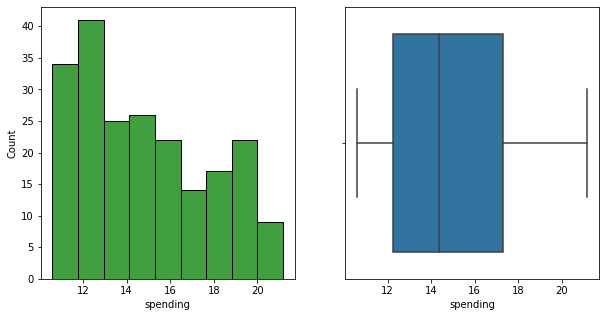

UVA of ADVANCE_PAYMENTS


<Figure size 432x288 with 0 Axes>

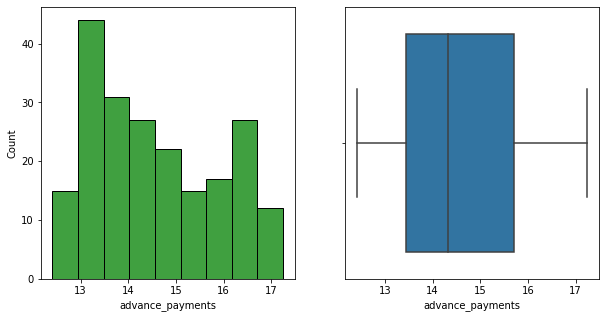

UVA of PROBABILITY_OF_FULL_PAYMENT


<Figure size 432x288 with 0 Axes>

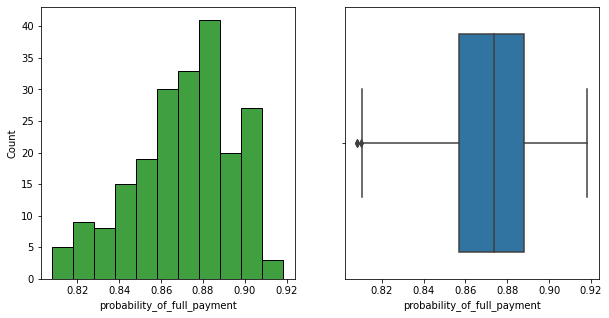

UVA of CURRENT_BALANCE


<Figure size 432x288 with 0 Axes>

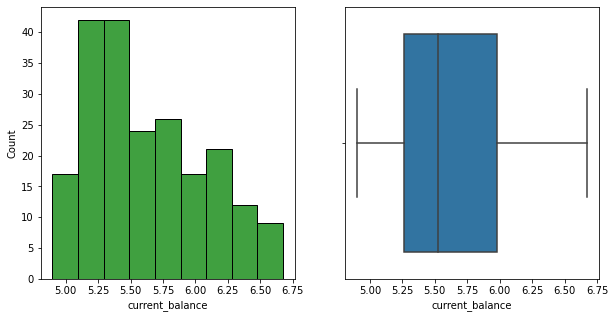

UVA of CREDIT_LIMIT


<Figure size 432x288 with 0 Axes>

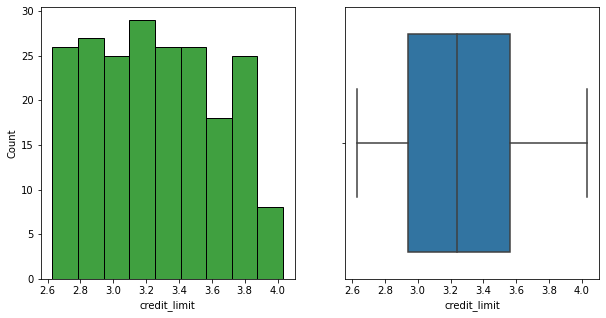

UVA of MIN_PAYMENT_AMT


<Figure size 432x288 with 0 Axes>

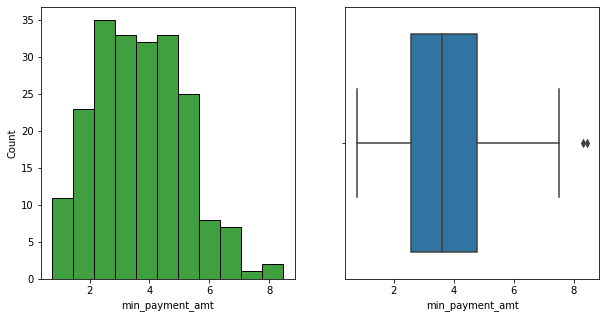

UVA of MAX_SPENT_IN_SINGLE_SHOPPING


<Figure size 432x288 with 0 Axes>

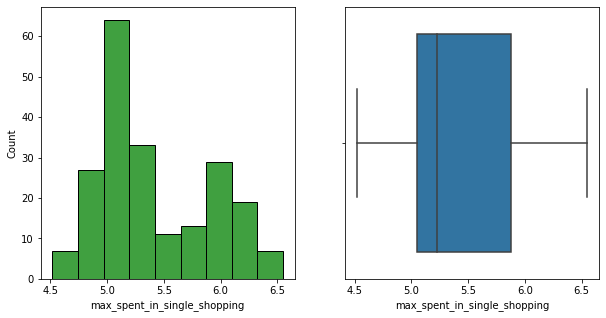

In [10]:
for x in list(cust.columns.values):
    univariateAnalysis_numeric(x,20)

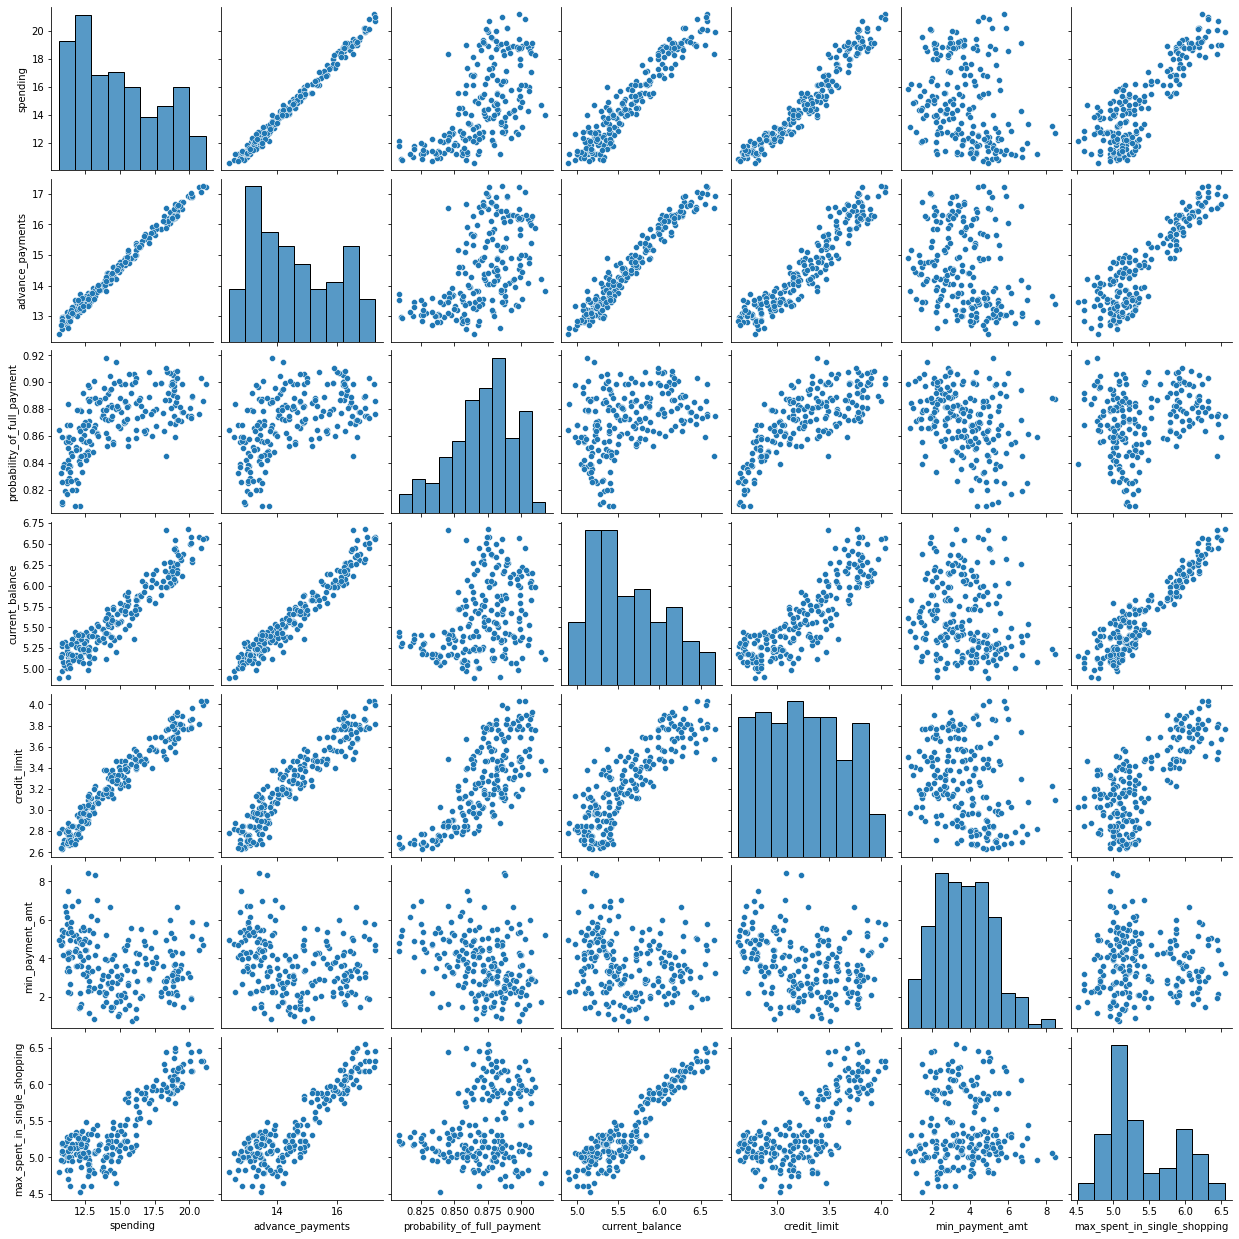

In [11]:
sns.pairplot(cust)

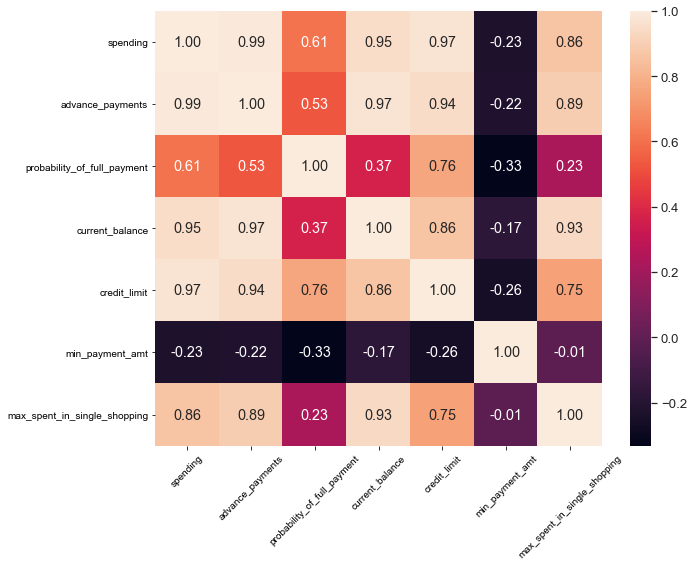

In [12]:
fig = plt.subplots(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(cust.corr(), annot=True,fmt='.2f')
plt.xticks(rotation = 45)
plt.show()

# Scaling:

Since clustering is based on distance metrics, scaling is required. We can observe differences a large difference between the minimum and maximum values in some of the features in the given dataset as well as irregularities in the means and stds. Hence scaling is essential.  

In [13]:
X = StandardScaler()
scaled_df = X.fit_transform(cust)
scaled_df

array([[ 1.75435461,  1.81196782,  0.17822987, ...,  1.33857863,
        -0.29880602,  2.3289982 ],
       [ 0.39358228,  0.25383997,  1.501773  , ...,  0.85823561,
        -0.24280501, -0.53858174],
       [ 1.41330028,  1.42819249,  0.50487353, ...,  1.317348  ,
        -0.22147129,  1.50910692],
       ...,
       [-0.2816364 , -0.30647202,  0.36488339, ..., -0.15287318,
        -1.3221578 , -0.83023461],
       [ 0.43836719,  0.33827054,  1.23027698, ...,  0.60081421,
        -0.95348449,  0.07123789],
       [ 0.24889256,  0.45340314, -0.77624835, ..., -0.07325831,
        -0.70681338,  0.96047321]])

# Hierarchical Clustering

In [14]:
wardlink = linkage(scaled_df, method = 'ward')

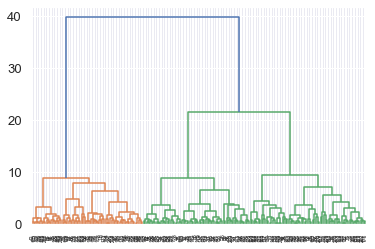

In [15]:
dend = dendrogram(wardlink)

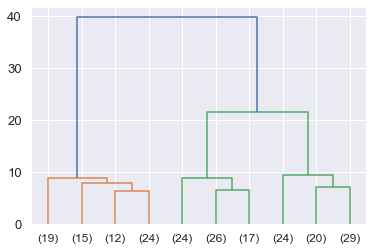

In [16]:
dend = dendrogram(wardlink,
                 truncate_mode='lastp',
                 p = 10,
                 )

In [46]:
clusters = fcluster(wardlink, 2, criterion='maxclust')
clusters

array([1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1,
       2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1,
       1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1,
       1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1,
       2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1,
       2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2,
       1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2], dtype=int32)

In [18]:
clusters = fcluster(wardlink, 25, criterion='distance')
clusters

array([1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1,
       2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1,
       1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1,
       1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1,
       2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1,
       2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2,
       1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2], dtype=int32)

# K-Means Clustering

In [19]:
k_means = KMeans(n_clusters = 3)
k_means.fit(scaled_df)

labels = k_means.labels_

In [20]:
k_means.labels_

array([1, 2, 1, 0, 1, 0, 0, 2, 1, 0, 1, 2, 0, 1, 2, 0, 2, 0, 0, 0, 0, 0,
       1, 0, 2, 1, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1,
       0, 0, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 2, 0, 0, 2, 2, 1,
       1, 2, 1, 0, 2, 0, 1, 1, 0, 1, 2, 0, 1, 2, 2, 2, 2, 1, 0, 2, 1, 2,
       1, 0, 2, 1, 2, 0, 0, 1, 1, 1, 0, 1, 2, 1, 2, 1, 2, 1, 1, 0, 0, 1,
       2, 2, 1, 0, 0, 1, 2, 2, 0, 1, 2, 0, 0, 0, 2, 2, 1, 0, 2, 2, 0, 2,
       2, 1, 0, 1, 1, 0, 1, 2, 2, 2, 0, 0, 2, 0, 1, 0, 2, 0, 2, 0, 2, 2,
       0, 2, 2, 0, 2, 1, 1, 0, 1, 1, 1, 0, 2, 2, 2, 0, 2, 0, 2, 1, 1, 1,
       2, 0, 2, 0, 2, 2, 2, 2, 1, 1, 0, 2, 2, 0, 0, 2, 0, 1, 2, 1, 1, 0,
       1, 0, 2, 1, 2, 0, 1, 2, 1, 2, 2, 2])

In [21]:
k_means.inertia_

430.6589731513006

In [22]:
wss =[] 

In [23]:
for i in range(1,11):
    KM = KMeans(n_clusters=i)
    KM.fit(scaled_df)
    wss.append(KM.inertia_)

In [24]:
wss

[1469.9999999999998,
 659.171754487041,
 430.6589731513006,
 371.2941183362073,
 327.05106145316563,
 290.09624616601144,
 263.28899226446885,
 240.36954998843814,
 220.90468456221933,
 207.75553830682577]

C:\Users\Vinay\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


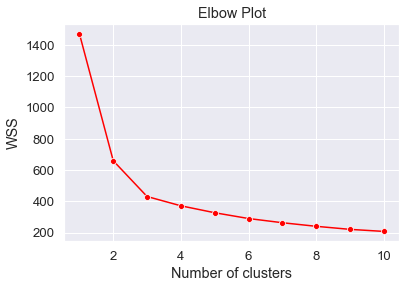

In [25]:
sns.lineplot(range(1,11),wss,marker='o',color='red')
plt.title('Elbow Plot')
plt.xlabel('Number of clusters')
plt.ylabel('WSS')
plt.show()


In [26]:
silhouette_score(scaled_df,labels)

0.4007270552751299

In [27]:
sil_width = silhouette_samples(scaled_df,labels)

In [28]:
sil_width.min()

0.002713089347678533

In [29]:
cust["clusters"] = k_means.labels_

In [30]:
cust.head()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,clusters
0,19.94,16.92,0.8752,6.675,3.763,3.252,6.550,1
1,15.99,14.89,0.9064,5.363,3.582,3.336,5.144,2
2,18.95,16.42,0.8829,6.248,3.755,3.368,6.148,1
3,10.83,12.96,0.8099,5.278,2.641,5.182,5.185,0
4,17.99,15.86,0.8992,5.890,3.694,2.068,5.837,1


In [145]:
cluster0 = cust[cust["clusters"]== 0]
cluster0.mean()

spending                        14.437887
advance_payments                14.337746
probability_of_full_payment      0.881597
current_balance                  5.514577
credit_limit                     3.259225
min_payment_amt                  2.707341
max_spent_in_single_shopping     5.120803
clusters                         0.000000
dtype: float64

In [146]:
cluster1 = cust[cust["clusters"]== 1]
cluster1.mean()

spending                        11.856944
advance_payments                13.247778
probability_of_full_payment      0.848253
current_balance                  5.231750
credit_limit                     2.849542
min_payment_amt                  4.742389
max_spent_in_single_shopping     5.101722
clusters                         1.000000
dtype: float64

In [147]:
cluster2 = cust[cust["clusters"]== 2]
cluster2.mean()

spending                        18.495373
advance_payments                16.203433
probability_of_full_payment      0.884210
current_balance                  6.175687
credit_limit                     3.697537
min_payment_amt                  3.632373
max_spent_in_single_shopping     6.041701
clusters                         2.000000
dtype: float64

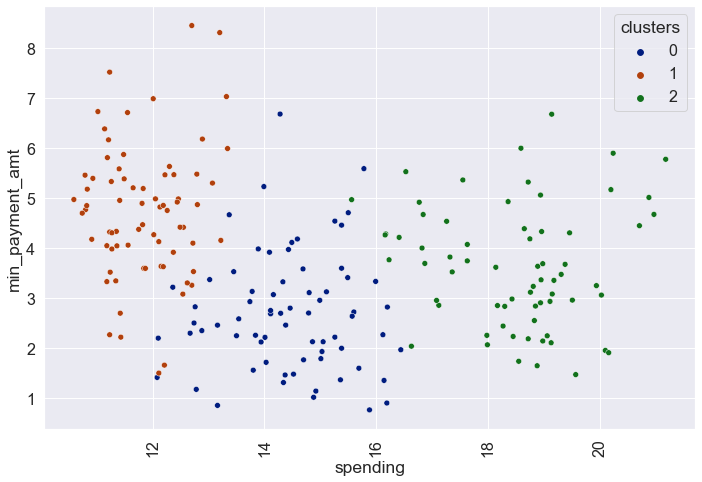

In [160]:
sns.set(font_scale = 1.5)
fig=plt.figure(figsize=(12,8), dpi= 70, facecolor='w', edgecolor='k')
sns.scatterplot(x = "spending", y = "min_payment_amt", hue = "clusters",palette = 'dark', data = cust, ci = None)
plt.xticks(rotation = 90)
plt.show()

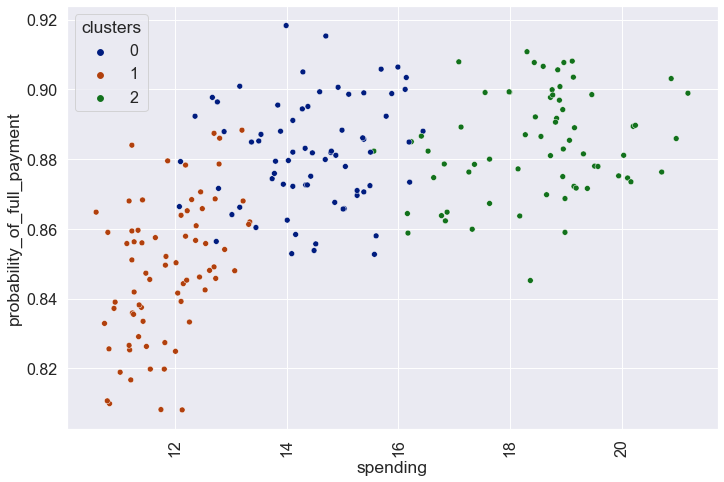

In [153]:
sns.set(font_scale = 1.5)
fig=plt.figure(figsize=(12,8), dpi= 70, facecolor='w', edgecolor='k')
sns.scatterplot(x = "spending", y = "probability_of_full_payment", hue = "clusters",palette = 'dark', data = cust, ci = None)
plt.xticks(rotation = 90)
plt.show()

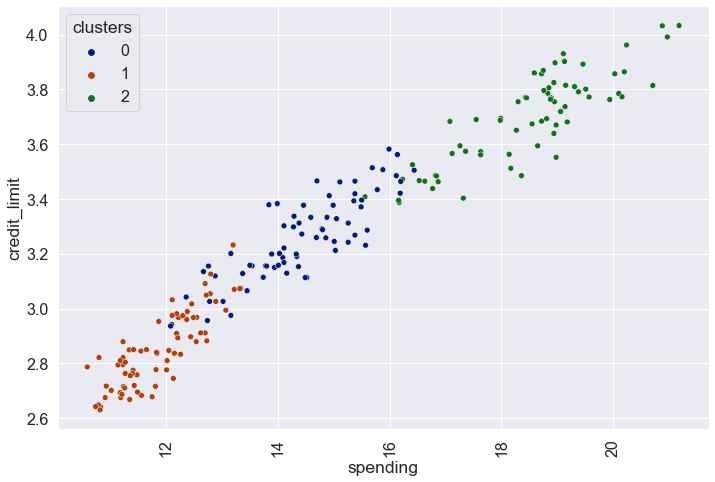

In [159]:
sns.set(font_scale = 1.5)
fig=plt.figure(figsize=(12,8), dpi= 70, facecolor='w', edgecolor='k')
sns.scatterplot(x = "spending", y = "credit_limit", hue = "clusters",palette = 'dark', data = cust, ci = None)
plt.xticks(rotation = 90)
plt.show()

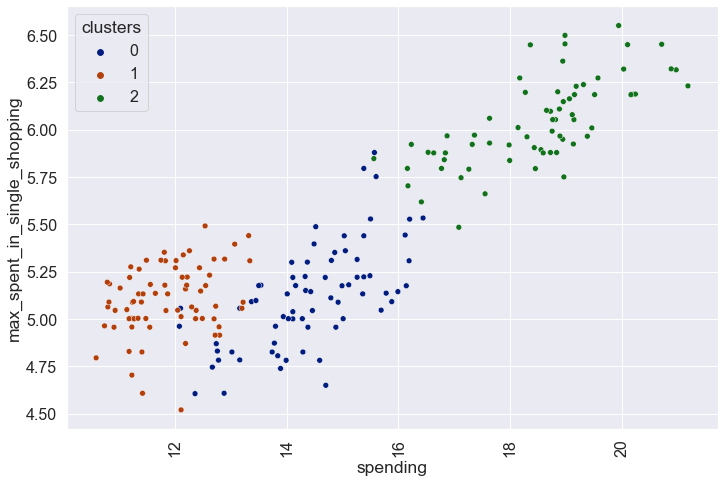

In [158]:
sns.set(font_scale = 1.5)
fig=plt.figure(figsize=(12,8), dpi= 70, facecolor='w', edgecolor='k')
sns.scatterplot(x = "spending", y = "max_spent_in_single_shopping", hue = "clusters",palette = 'dark', data = cust, ci = None)
plt.xticks(rotation = 90)
plt.show()

# Problem 2

# An Insurance firm providing tour insurance is facing higher claim frequency. The management decides to collect data from the past few years. You are assigned the task to make a model which predicts the claim status and provide recommendations to management. Use CART, RF & ANN and compare the models' performances in train and test sets.

In [34]:
insure = pd.read_csv("insurance_part2_data.csv")

In [35]:
insure.head()

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
0,48,C2B,Airlines,No,0.70,Online,7,2.51,Customised Plan,ASIA
1,36,EPX,Travel Agency,No,0.00,Online,34,20.00,Customised Plan,ASIA
2,39,CWT,Travel Agency,No,5.94,Online,3,9.90,Customised Plan,Americas
3,36,EPX,Travel Agency,No,0.00,Online,4,26.00,Cancellation Plan,ASIA
4,33,JZI,Airlines,No,6.30,Online,53,18.00,Bronze Plan,ASIA


In [36]:
insure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           3000 non-null   int64  
 1   Agency_Code   3000 non-null   object 
 2   Type          3000 non-null   object 
 3   Claimed       3000 non-null   object 
 4   Commision     3000 non-null   float64
 5   Channel       3000 non-null   object 
 6   Duration      3000 non-null   int64  
 7   Sales         3000 non-null   float64
 8   Product Name  3000 non-null   object 
 9   Destination   3000 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 234.5+ KB


In [37]:
insure.columns

Index(['Age', 'Agency_Code', 'Type', 'Claimed', 'Commision', 'Channel',
       'Duration', 'Sales', 'Product Name', 'Destination'],
      dtype='object')

Target: Claim Status (Claimed)
2. Code of tour firm (Agency_Code)
3. Type of tour insurance firms (Type)
4. Distribution channel of tour insurance agencies (Channel)
5. Name of the tour insurance products (Product)
6. Duration of the tour (Duration)
7. Destination of the tour (Destination)
8. Amount of sales of tour insurance policies (Sales)
9. The commission received for tour insurance firm (Commission)
10. Age of insured (Age)

In [78]:
insure.describe(include = "all")

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
count,3000.000000,3000,3000,3000,3000.000000,3000,3000.000000,3000.000000,3000,3000
unique,NaN,4,2,2,NaN,2,NaN,NaN,5,3
top,NaN,EPX,Travel Agency,No,NaN,Online,NaN,NaN,Customised Plan,ASIA
freq,NaN,1365,1837,2076,NaN,2954,NaN,NaN,1136,2465
mean,38.091000,NaN,NaN,NaN,14.529203,NaN,70.001333,60.249913,NaN,NaN
std,10.463518,NaN,NaN,NaN,25.481455,NaN,134.053313,70.733954,NaN,NaN
min,8.000000,NaN,NaN,NaN,0.000000,NaN,-1.000000,0.000000,NaN,NaN
25%,32.000000,NaN,NaN,NaN,0.000000,NaN,11.000000,20.000000,NaN,NaN
50%,36.000000,NaN,NaN,NaN,4.630000,NaN,26.500000,33.000000,NaN,NaN
75%,42.000000,NaN,NaN,NaN,17.235000,NaN,63.000000,69.000000,NaN,NaN


In [43]:
insure.isnull().sum()

Age             0
Agency_Code     0
Type            0
Claimed         0
Commision       0
Channel         0
Duration        0
Sales           0
Product Name    0
Destination     0
dtype: int64

In [49]:
dups = insure.duplicated()

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
63,30,C2B,Airlines,Yes,15.0,Online,27,60.0,Bronze Plan,ASIA
329,36,EPX,Travel Agency,No,0.0,Online,5,20.0,Customised Plan,ASIA
407,36,EPX,Travel Agency,No,0.0,Online,11,19.0,Cancellation Plan,ASIA
411,35,EPX,Travel Agency,No,0.0,Online,2,20.0,Customised Plan,ASIA
422,36,EPX,Travel Agency,No,0.0,Online,5,20.0,Customised Plan,ASIA
...,...,...,...,...,...,...,...,...,...,...
2940,36,EPX,Travel Agency,No,0.0,Online,8,10.0,Cancellation Plan,ASIA
2947,36,EPX,Travel Agency,No,0.0,Online,10,28.0,Customised Plan,ASIA
2952,36,EPX,Travel Agency,No,0.0,Online,2,10.0,Cancellation Plan,ASIA
2962,36,EPX,Travel Agency,No,0.0,Online,4,20.0,Customised Plan,ASIA


In [74]:
insure.Type.unique()

array(['Airlines', 'Travel Agency'], dtype=object)

In [50]:
dups.sum()

139

In [51]:
insure.shape

(3000, 10)

In [54]:
df = insure.drop_duplicates()
df

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
0,48,C2B,Airlines,No,0.70,Online,7,2.51,Customised Plan,ASIA
1,36,EPX,Travel Agency,No,0.00,Online,34,20.00,Customised Plan,ASIA
2,39,CWT,Travel Agency,No,5.94,Online,3,9.90,Customised Plan,Americas
3,36,EPX,Travel Agency,No,0.00,Online,4,26.00,Cancellation Plan,ASIA
4,33,JZI,Airlines,No,6.30,Online,53,18.00,Bronze Plan,ASIA
...,...,...,...,...,...,...,...,...,...,...
2995,28,CWT,Travel Agency,Yes,166.53,Online,364,256.20,Gold Plan,Americas
2996,35,C2B,Airlines,No,13.50,Online,5,54.00,Gold Plan,ASIA
2997,36,EPX,Travel Agency,No,0.00,Online,54,28.00,Customised Plan,ASIA
2998,34,C2B,Airlines,Yes,7.64,Online,39,30.55,Bronze Plan,ASIA


In [55]:
df.shape

(2861, 10)

In [56]:
df["Agency_Code"].value_counts()

EPX    1238
C2B     913
CWT     471
JZI     239
Name: Agency_Code, dtype: int64

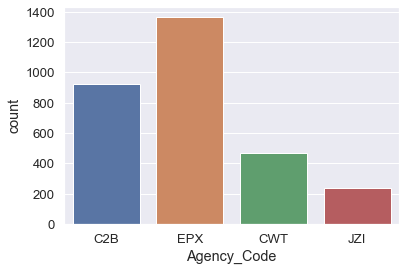

In [100]:
sns.countplot(x = "Agency_Code", data = insure)
plt.show()

In [57]:
df.Type.value_counts()

Travel Agency    1709
Airlines         1152
Name: Type, dtype: int64

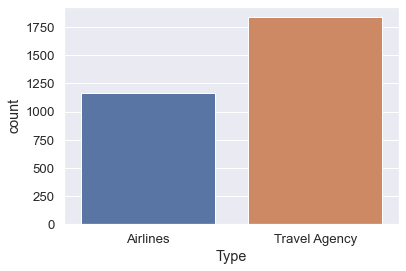

In [99]:
sns.countplot(x = "Type", data = insure)
plt.show()

In [58]:
df["Product Name"].value_counts()

Customised Plan      1071
Bronze Plan           645
Cancellation Plan     615
Silver Plan           421
Gold Plan             109
Name: Product Name, dtype: int64

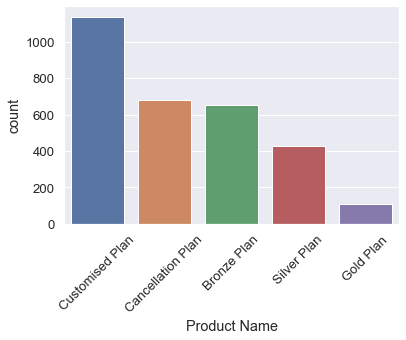

In [98]:
sns.countplot(x = "Product Name", data = insure)
plt.xticks(rotation = 45)
plt.show()

In [59]:
df.Destination.value_counts()

ASIA        2327
Americas     319
EUROPE       215
Name: Destination, dtype: int64

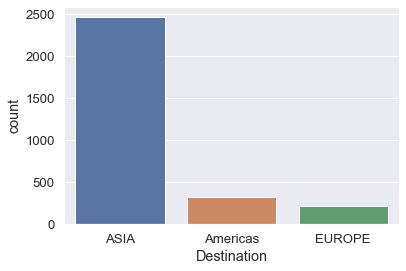

In [95]:
sns.countplot(x = "Destination", data = insure)
plt.show()

In [62]:
df.Channel.value_counts()

Online     2815
Offline      46
Name: Channel, dtype: int64

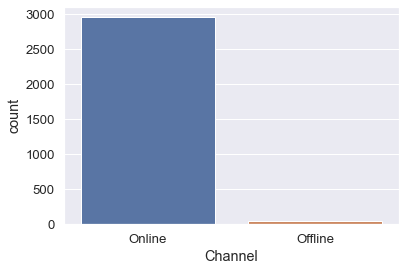

In [96]:
sns.countplot(x = "Channel", data = insure)
plt.show()

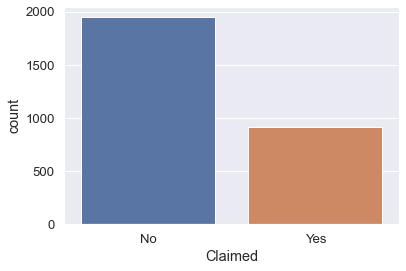

In [60]:
sns.countplot(x = "Claimed", data = df)
plt.show()

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2861 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           2861 non-null   int64  
 1   Agency_Code   2861 non-null   object 
 2   Type          2861 non-null   object 
 3   Claimed       2861 non-null   object 
 4   Commision     2861 non-null   float64
 5   Channel       2861 non-null   object 
 6   Duration      2861 non-null   int64  
 7   Sales         2861 non-null   float64
 8   Product Name  2861 non-null   object 
 9   Destination   2861 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 325.9+ KB


In [83]:
insure_plt = insure.drop(["Agency_Code", "Type", "Claimed", "Channel", "Product Name", "Destination"], axis = 1)

# Univariate Analysis: 

In [84]:
def univariateAnalysis_numeric(column,nbins):
    
    plt.figure()
    fig,axs = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
    print("UVA of " + column.upper())
    sns.histplot(insure_plt[column], kde=False, color='g', ax=axs[0])
    sns.boxplot(x=insure_plt[column], ax=axs[1])
    plt.show()

UVA of AGE


<Figure size 432x288 with 0 Axes>

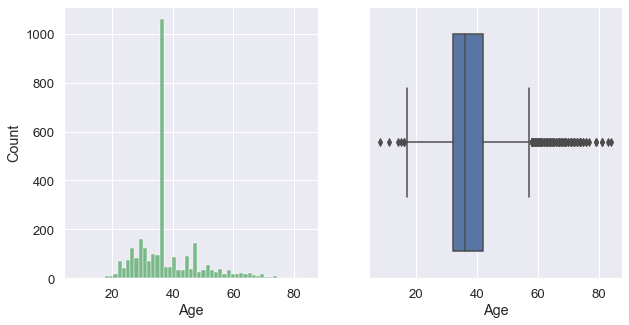

UVA of COMMISION


<Figure size 432x288 with 0 Axes>

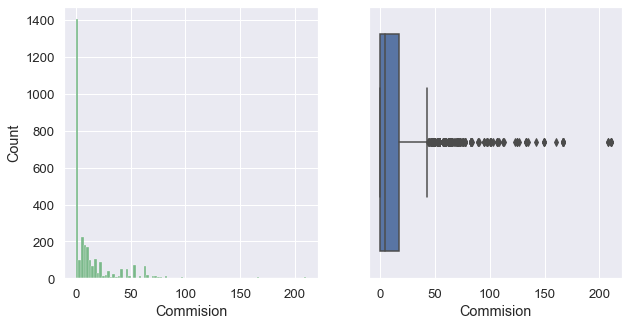

UVA of DURATION


<Figure size 432x288 with 0 Axes>

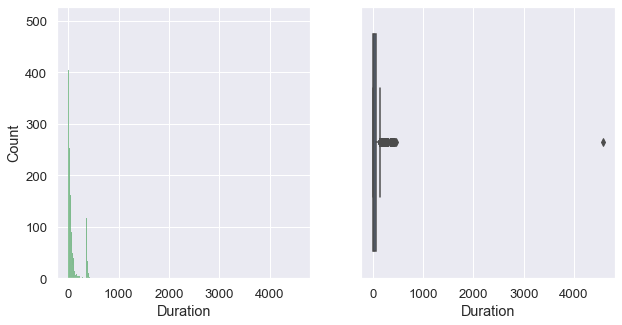

UVA of SALES


<Figure size 432x288 with 0 Axes>

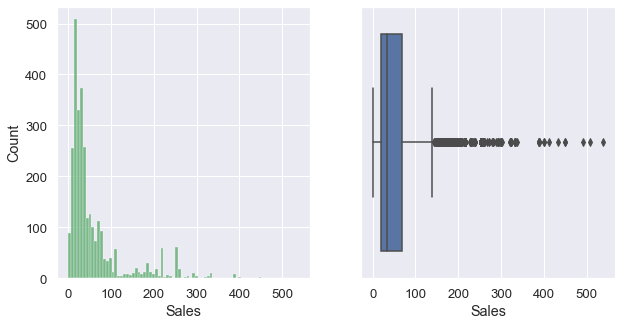

In [85]:
for x in list(insure_plt.columns.values):
    univariateAnalysis_numeric(x,20)

# Multi-Variate Analysis: 

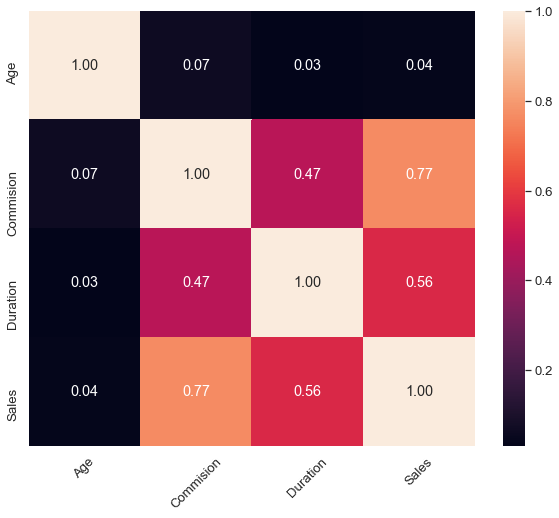

In [79]:
fig = plt.subplots(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(insure.corr(), annot=True,fmt='.2f')
plt.xticks(rotation = 45)
plt.show()

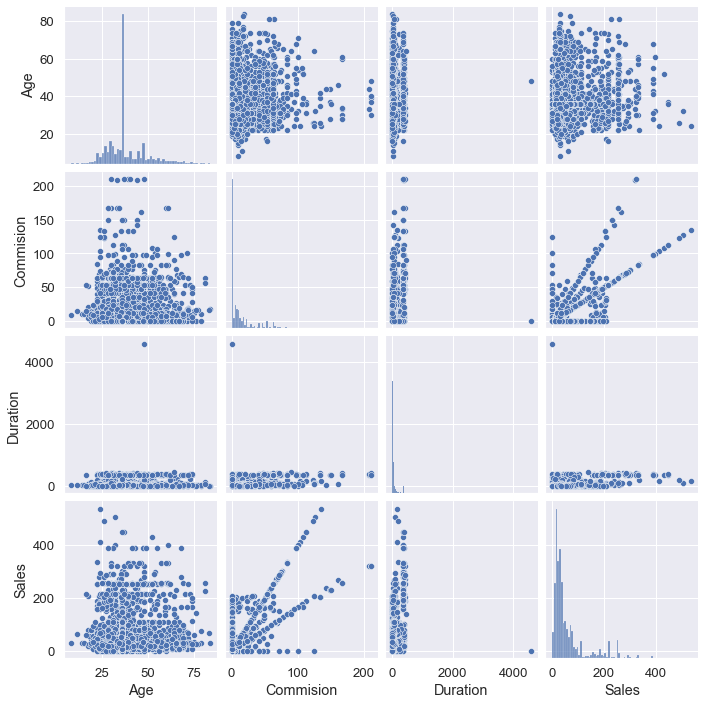

In [86]:
sns.pairplot(insure)

# Converting Object dtype to Categorical: 

In [103]:
for column in df[['Agency_Code','Type','Claimed','Channel', 'Product Name', 'Destination']]:
    if df[column].dtype == 'object':
        df[column] = pd.Categorical(df[column]).codes 

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2861 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           2861 non-null   int64  
 1   Agency_Code   2861 non-null   int8   
 2   Type          2861 non-null   int8   
 3   Claimed       2861 non-null   int8   
 4   Commision     2861 non-null   float64
 5   Channel       2861 non-null   int8   
 6   Duration      2861 non-null   int64  
 7   Sales         2861 non-null   float64
 8   Product Name  2861 non-null   int8   
 9   Destination   2861 non-null   int8   
dtypes: float64(2), int64(2), int8(6)
memory usage: 208.5 KB


In [105]:
df.head()

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
0,48,0,0,0,0.70,1,7,2.51,2,0
1,36,2,1,0,0.00,1,34,20.00,2,0
2,39,1,1,0,5.94,1,3,9.90,2,1
3,36,2,1,0,0.00,1,4,26.00,1,0
4,33,3,0,0,6.30,1,53,18.00,0,0


In [109]:
df.Claimed.value_counts(normalize= True)

0    0.680531
1    0.319469
Name: Claimed, dtype: float64

# Train-Test Split

In [106]:
X = df.drop("Claimed", axis = 1)
y = df["Claimed"]

In [110]:
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size = 0.30, random_state = 1)

In [111]:
print('X_train: ',X_train.shape)
print('X_test: ',X_test.shape)
print('y_train: ',y_train.shape)
print('y_test: ',y_test.shape)

X_train:  (2002, 9)
X_test:  (859, 9)
y_train:  (2002,)
y_test:  (859,)


In [113]:
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

# CART 

In [116]:
dtcl=DecisionTreeClassifier(random_state=1)

In [117]:
dtcl.fit(X_train,y_train)

DecisionTreeClassifier(random_state=1)

# Random Forest

In [120]:
rfcl=RandomForestClassifier(random_state=1)

In [121]:
rfcl.fit(X_train,y_train)

RandomForestClassifier(random_state=1)

# ANN

In [124]:
mlp=MLPClassifier(hidden_layer_sizes=(500),solver='sgd',random_state=1,max_iter=500)

In [125]:
mlp.fit(X_train,y_train)

MLPClassifier(hidden_layer_sizes=500, max_iter=500, random_state=1,
              solver='sgd')

# Grid Search on DTCL

In [130]:
param_grid = {
    'criterion': ['gini'],
    'max_depth': [5,7,9,10],
    'min_samples_leaf': [15,30,45,90], 
    'min_samples_split': [150,300,450],
}

dtcl = DecisionTreeClassifier(random_state=1)

grid_search = GridSearchCV(estimator = dtcl, param_grid = param_grid, cv = 5)

In [131]:
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
best_grid = grid_search.best_estimator_
best_grid

{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 300}


DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=300,
                       random_state=1)

In [132]:
ytrain_predict = best_grid.predict(X_train)
ytest_predict = best_grid.predict(X_test)

In [134]:
ytest_predict_prob=best_grid.predict_proba(X_test)
ytest_predict_prob

array([[0.57317073, 0.42682927],
       [0.97122302, 0.02877698],
       [0.23297491, 0.76702509],
       ...,
       [0.46283784, 0.53716216],
       [0.88479263, 0.11520737],
       [0.72222222, 0.27777778]])

In [137]:
pd.DataFrame(ytest_predict_prob)

,0,1
0,0.573171,0.426829
1,0.971223,0.028777
2,0.232975,0.767025
3,0.837500,0.162500
4,0.837500,0.162500
...,...,...
854,0.884793,0.115207
855,0.884793,0.115207
856,0.462838,0.537162
857,0.884793,0.115207


In [119]:
print (pd.DataFrame(best_grid.feature_importances_, columns = ["Imp"], index = X.columns).sort_values('Imp',ascending=False))

                   Imp
Agency_Code   0.600450
Sales         0.304966
Product Name  0.047357
Duration      0.018764
Commision     0.014732
Age           0.013731
Type          0.000000
Channel       0.000000
Destination   0.000000


C:\Users\Vinay\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


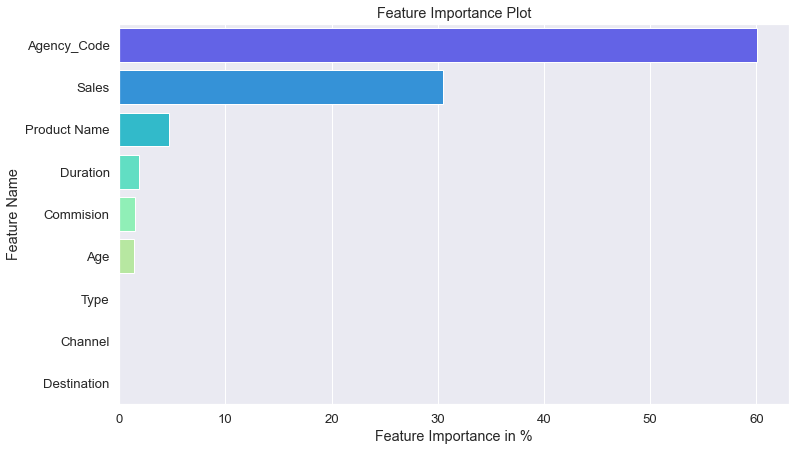

In [139]:
x=pd.DataFrame(best_grid.feature_importances_*100,index=X.columns).sort_values(by=0,ascending=False)
plt.figure(figsize=(12,7))
sns.barplot(x[0],x.index,palette='rainbow')
plt.ylabel('Feature Name')
plt.xlabel('Feature Importance in %')
plt.title('Feature Importance Plot')
plt.show()

# Grid Search on RTCL

In [143]:
param_grid = {
    'max_depth': [5,7,10],
    'max_features': [4,6],
    'min_samples_leaf': [5,10],
    'min_samples_split': [50,100],
    'n_estimators': [100,200,300]
}

rfcl = RandomForestClassifier(random_state=1)

grid_search = GridSearchCV(estimator = rfcl, param_grid = param_grid, cv = 5)

In [144]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_depth': [5, 7, 10], 'max_features': [4, 6],
                         'min_samples_leaf': [5, 10],
                         'min_samples_split': [50, 100],
                         'n_estimators': [100, 200, 300]})

In [145]:
print(grid_search.best_params_)

{'max_depth': 10, 'max_features': 6, 'min_samples_leaf': 5, 'min_samples_split': 50, 'n_estimators': 300}


In [146]:
best_grid = grid_search.best_estimator_
best_grid

RandomForestClassifier(max_depth=10, max_features=6, min_samples_leaf=5,
                       min_samples_split=50, n_estimators=300, random_state=1)

In [147]:
ytrain_predict = best_grid.predict(X_train)
ytest_predict = best_grid.predict(X_test)

In [148]:
ytest_predict_prob=best_grid.predict_proba(X_test)
pd.DataFrame(ytest_predict_prob)

,0,1
0,0.453923,0.546077
1,0.920116,0.079884
2,0.353366,0.646634
3,0.851290,0.148710
4,0.719868,0.280132
...,...,...
854,0.590098,0.409902
855,0.912144,0.087856
856,0.533267,0.466733
857,0.929974,0.070026


In [149]:
print (pd.DataFrame(best_grid.feature_importances_, columns = ["Imp"], index = X.columns).sort_values('Imp',ascending=False))

                   Imp
Agency_Code   0.311297
Sales         0.206403
Product Name  0.164764
Duration      0.110162
Commision     0.097125
Age           0.075911
Type          0.015241
Destination   0.014818
Channel       0.004279


C:\Users\Vinay\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


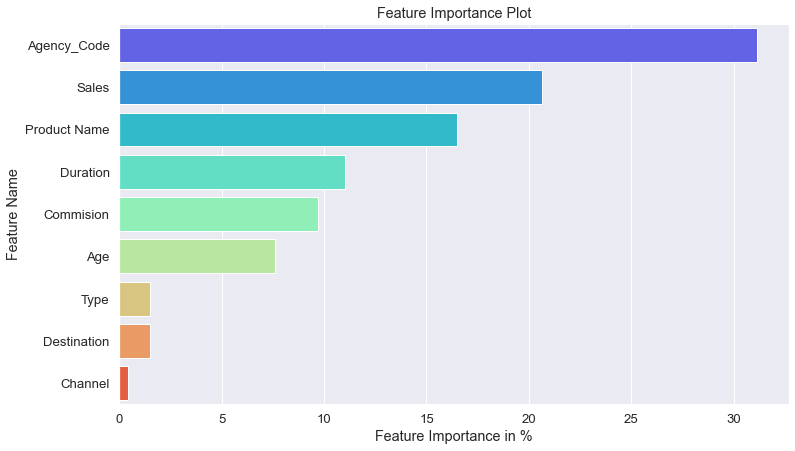

In [150]:
x=pd.DataFrame(best_grid.feature_importances_*100,index=X.columns).sort_values(by=0,ascending=False)
plt.figure(figsize=(12,7))
sns.barplot(x[0],x.index,palette='rainbow')
plt.ylabel('Feature Name')
plt.xlabel('Feature Importance in %')
plt.title('Feature Importance Plot')
plt.show()

# Grid Search on ANN

In [160]:
param_grid = {
    'hidden_layer_sizes': [100,200,300,500],
    'max_iter': [5000,2500,7000,6000],
    'solver': ['sgd','adam'],
    'tol': [0.01],
}

mlp = MLPClassifier(random_state=1)

grid_search = GridSearchCV(estimator = mlp, param_grid = param_grid, cv = 5)

In [161]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=MLPClassifier(random_state=1),
             param_grid={'hidden_layer_sizes': [100, 200, 300, 500],
                         'max_iter': [5000, 2500, 7000, 6000],
                         'solver': ['sgd', 'adam'], 'tol': [0.01]})

In [162]:
grid_search.best_params_

{'hidden_layer_sizes': 300, 'max_iter': 5000, 'solver': 'adam', 'tol': 0.01}

In [163]:
best_grid = grid_search.best_estimator_
best_grid

MLPClassifier(hidden_layer_sizes=300, max_iter=5000, random_state=1, tol=0.01)

In [164]:
ytrain_predict = best_grid.predict(X_train)
ytest_predict = best_grid.predict(X_test)

In [165]:
ytest_predict_prob=best_grid.predict_proba(X_test)
pd.DataFrame(ytest_predict_prob)

,0,1
0,0.456584,0.543416
1,0.932504,0.067496
2,0.429285,0.570715
3,0.765057,0.234943
4,0.726160,0.273840
...,...,...
854,0.610586,0.389414
855,0.889450,0.110550
856,0.524701,0.475299
857,0.911125,0.088875


# Comparing Performance Metrics on Train Set

In [176]:
models=[dtcl,rfcl,mlp]
models_names={dtcl:'DecisionTreeClassifier',rfcl:'RandomForestClassifier',mlp:'ANN'}

Accuracy for DecisionTreeClassifier model is 
 0.9955044955044955


Classification report for DecisionTreeClassifier model is 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1359
           1       1.00      0.99      0.99       643

    accuracy                           1.00      2002
   macro avg       1.00      0.99      0.99      2002
weighted avg       1.00      1.00      1.00      2002



Confusion Matrix for DecisionTreeClassifier model is


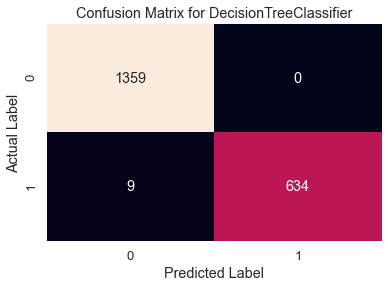

Accuracy for RandomForestClassifier model is 
 0.9955044955044955


Classification report for RandomForestClassifier model is 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1359
           1       0.99      0.99      0.99       643

    accuracy                           1.00      2002
   macro avg       1.00      0.99      0.99      2002
weighted avg       1.00      1.00      1.00      2002



Confusion Matrix for RandomForestClassifier model is


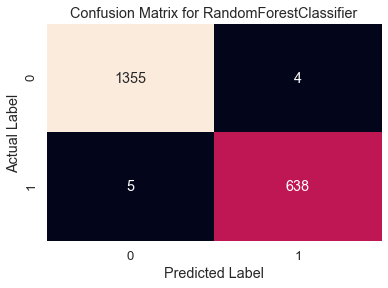

Accuracy for ANN model is 
 0.7597402597402597


Classification report for ANN model is 
               precision    recall  f1-score   support

           0       0.79      0.88      0.83      1359
           1       0.67      0.51      0.57       643

    accuracy                           0.76      2002
   macro avg       0.73      0.69      0.70      2002
weighted avg       0.75      0.76      0.75      2002



Confusion Matrix for ANN model is


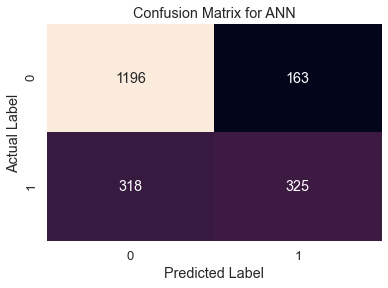

In [177]:
for i in models:
    i.fit(X_train,y_train)
    print('Accuracy for {} model is'.format(models_names[i]),'\n',accuracy_score(y_train,i.predict(X_train)))
    print('\n')
    print('Classification report for {} model is'.format(models_names[i]),'\n',classification_report(y_train,i.predict(X_train)))
    print('\n')
    print('Confusion Matrix for {} model is'.format(models_names[i]))
    sns.heatmap(confusion_matrix(y_train,i.predict(X_train)),annot=True,fmt='d',cbar=False)
    plt.title('Confusion Matrix for {}'.format(models_names[i]))
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.show()

Area under the curve for Decision Tree Classification Model is 0.9999536526835096
Area under the curve for Random Forest Classification Model is 0.9999319094979955
Area under the curve for Artificial Neural Network Model is 0.8066029476893288


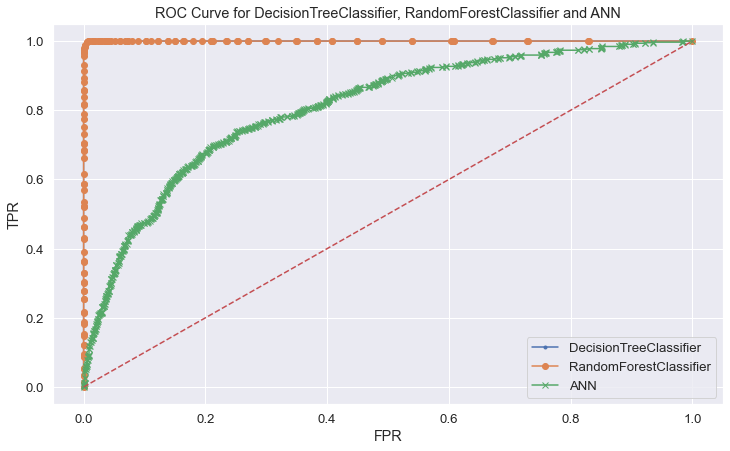

In [178]:
print('Area under the curve for Decision Tree Classification Model is',roc_auc_score(y_train,dtcl.predict_proba(X_train)[:,1]))
print('Area under the curve for Random Forest Classification Model is',roc_auc_score(y_train,rfcl.predict_proba(X_train)[:,1]))
print('Area under the curve for Artificial Neural Network Model is',roc_auc_score(y_train,mlp.predict_proba(X_train)[:,1]))

plt.figure(figsize=(12,7))
fpr_dtc, tpr_dtc, thresholds = roc_curve(y_train, dtcl.predict_proba(X_train)[:,1])
plt.plot(fpr_dtc, tpr_dtc, marker='.') 

fpr_rfc, tpr_rfc, thresholds = roc_curve(y_train, rfcl.predict_proba(X_train)[:,1])
plt.plot(fpr_rfc, tpr_rfc, marker='o') 

fpr_ann, tpr_ann, thresholds = roc_curve(y_train, mlp.predict_proba(X_train)[:,1])
plt.plot(fpr_ann, tpr_ann, marker='x',) 
plt.plot([0, 1], [0, 1], linestyle='--')

plt.title('ROC Curve for {}'.format('DecisionTreeClassifier, RandomForestClassifier and ANN'))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(models_names.values())
plt.show()

# Comparing Models on Test Set

In [179]:
models=[dtcl,rfcl,mlp]
models_names={dtcl:'DecisionTreeClassifier',rfcl:'RandomForestClassifier',mlp:'ANN'}

Accuracy for DecisionTreeClassifier model is 
 0.7008149010477299


Classification report for DecisionTreeClassifier model is 
               precision    recall  f1-score   support

           0       0.78      0.79      0.78       588
           1       0.53      0.50      0.51       271

    accuracy                           0.70       859
   macro avg       0.65      0.65      0.65       859
weighted avg       0.70      0.70      0.70       859



Confusion Matrix for DecisionTreeClassifier model is


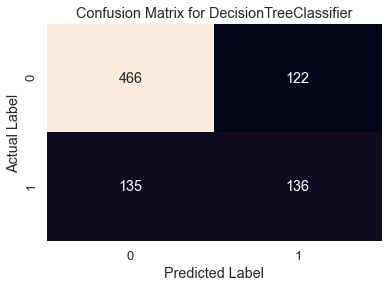

Accuracy for RandomForestClassifier model is 
 0.7543655413271245


Classification report for RandomForestClassifier model is 
               precision    recall  f1-score   support

           0       0.80      0.85      0.83       588
           1       0.62      0.55      0.59       271

    accuracy                           0.75       859
   macro avg       0.71      0.70      0.71       859
weighted avg       0.75      0.75      0.75       859



Confusion Matrix for RandomForestClassifier model is


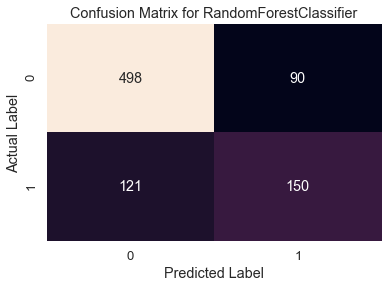

Accuracy for ANN model is 
 0.7671711292200233


Classification report for ANN model is 
               precision    recall  f1-score   support

           0       0.79      0.90      0.84       588
           1       0.69      0.48      0.57       271

    accuracy                           0.77       859
   macro avg       0.74      0.69      0.70       859
weighted avg       0.76      0.77      0.75       859



Confusion Matrix for ANN model is


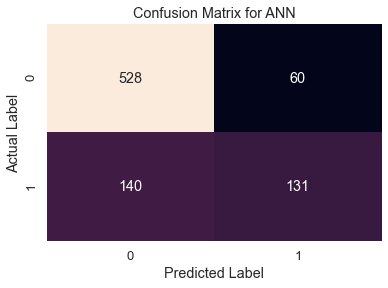

In [180]:
for i in models:
    i.fit(X_train,y_train)
    print('Accuracy for {} model is'.format(models_names[i]),'\n',accuracy_score(y_test,i.predict(X_test)))
    print('\n')
    print('Classification report for {} model is'.format(models_names[i]),'\n',classification_report(y_test,i.predict(X_test)))
    print('\n')
    print('Confusion Matrix for {} model is'.format(models_names[i]))
    sns.heatmap(confusion_matrix(y_test,i.predict(X_test)),annot=True,fmt='d',cbar=False)
    plt.title('Confusion Matrix for {}'.format(models_names[i]))
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.show()

Area under the curve for Decision Tree Classification Model is 0.647372417601727
Area under the curve for Random Forest Classification Model is 0.7780988779275547
Area under the curve for Artificial Neural Network Model is 0.8125611868363583


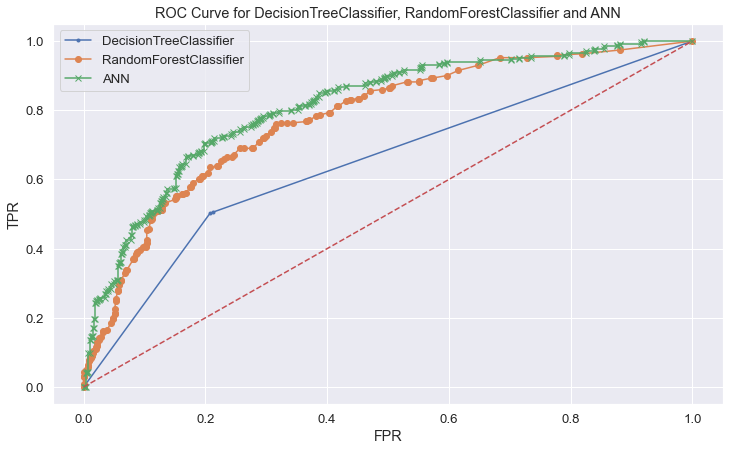

In [181]:
print('Area under the curve for Decision Tree Classification Model is',roc_auc_score(y_test,dtcl.predict_proba(X_test)[:,1]))
print('Area under the curve for Random Forest Classification Model is',roc_auc_score(y_test,rfcl.predict_proba(X_test)[:,1]))
print('Area under the curve for Artificial Neural Network Model is',roc_auc_score(y_test,mlp.predict_proba(X_test)[:,1]))

plt.figure(figsize=(12,7))
fpr_dtc, tpr_dtc, thresholds = roc_curve(y_test, dtcl.predict_proba(X_test)[:,1])
plt.plot(fpr_dtc, tpr_dtc, marker='.') 

fpr_rfc, tpr_rfc, thresholds = roc_curve(y_test, rfcl.predict_proba(X_test)[:,1])
plt.plot(fpr_rfc, tpr_rfc, marker='o') 

fpr_ann, tpr_ann, thresholds = roc_curve(y_test, mlp.predict_proba(X_test)[:,1])
plt.plot(fpr_ann, tpr_ann, marker='x',) 
plt.plot([0, 1], [0, 1], linestyle='--')

plt.title('ROC Curve for {}'.format('DecisionTreeClassifier, RandomForestClassifier and ANN'))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(models_names.values())
plt.show()